## Linear regression on the Boston House Prices dataset

In this exercise, you will perform linear regression on the Boston House Prices dataset.

This dataset contains median house prices in different areas around Boston. For each area, we have some information about it, that we will use as our features. We want to train a linear regression model that predicts the price of a house given the input features.

We don't have direct access to the dataset from PyTorch, but the `scikit` library provides a version of it.

An important part of the exercise will be to get used to process input dataset and translate it into a suitable format for your analysis.

In [1]:
# Import dataset
from sklearn.datasets import load_boston
dataset = load_boston()

Play around with the `dataset` variable to see what it contains. It is a *dictionary*, i.e. a Python structure with key-value pairs, where the keys can be arbitrary objects --- usually strings. 

To access the item with key `key` from a dictionary `dictionary`, use the syntax `dictionary[key]`.

The `keys()` method of a dictionary returns the set of keys. To start, try `print()`ing the contents of the the `DESCR` key.

The data in the dataset are Numpy arrays. To convert them to PyTorch tensors, just pass the array as the single argument of the `torch.tensor()` function.

From this point, prepare the data to process it as done in the previous exercise.

# **Exercise Solution by Salvatore Cavallaro, 1000008690 (Part I)**

First of all, we know that our *dataset* is a dictionary, therefore we would like to see its keys:

In [2]:
dataset.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])

We try to explore data inside the dictionary according to information just got above. In particular, *DESCR* should give us insights about the structure of our data.

In [3]:
dataset.get('DESCR')

".. _boston_dataset:\n\nBoston house prices dataset\n---------------------------\n\n**Data Set Characteristics:**  \n\n    :Number of Instances: 506 \n\n    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.\n\n    :Attribute Information (in order):\n        - CRIM     per capita crime rate by town\n        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.\n        - INDUS    proportion of non-retail business acres per town\n        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)\n        - NOX      nitric oxides concentration (parts per 10 million)\n        - RM       average number of rooms per dwelling\n        - AGE      proportion of owner-occupied units built prior to 1940\n        - DIS      weighted distances to five Boston employment centres\n        - RAD      index of accessibility to radial highways\n        - TAX      full-value property-tax rate per $10,000

In [4]:
dataset.get('feature_names')

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

Let's compute the shape of the dataset:

In [5]:
dataset.get('data').shape

(506, 13)

In [6]:
dataset.get('target').shape

(506,)

The next operation is importing the numpy array into a tensor. We also do a shuffle operation on it

In [7]:
import torch
data_tensor = torch.cat([torch.from_numpy(dataset.get('data')), torch.from_numpy(dataset.get('target')).unsqueeze(1)], 1)
data_tensor=data_tensor[torch.randperm(data_tensor.size()[0])]
X = data_tensor[:,:-1]
y = data_tensor[:,-1]

The next operation is to normalize our dataset in the range $0<=x<=1$:

In [9]:
print(X.min())

tensor(0., dtype=torch.float64)


In [10]:
print(X.max())

tensor(711., dtype=torch.float64)


In [13]:
X = (X-0.)/711.

In [14]:
print(X.min())

tensor(0., dtype=torch.float64)


In [15]:
print(X.max())

tensor(1., dtype=torch.float64)


Another important requirement to be satisfied is adapting our dataset to a Linear Regression Model: we need to add fake column of $x0=1$

In [16]:
x0 = torch.ones(X[:,:1].size())


We concatenate the result

In [17]:
X = torch.cat([x0, X], 1)

Now we have to split our dataset into *Training set* and *Test set*

In [18]:
import math

percentage_split = 0.8
N = list(y.size())[0]

num_training = math.floor(N*percentage_split)
num_test = N-num_training

In [19]:
y = y.unsqueeze(1)

In [20]:
X_training = X[:num_training,:]
y_training = y[:num_training,:]

X_test = X[num_training:, :]
y_test = y[num_training:, :]

## Feature analysis

### Correlations

One of the things you may want to do is remove unnecessary features. For example, if you have two highly-correlated features, you could use only one of them.

Feature correlation can be estimated using the Pearson correlation coefficient:

$$\text{corr}_{X_1,X_2} = \frac{\text{cov}(X_1,X_2)}{\sigma_{X_1} \sigma_{X_2}}$$

where $\text{cov}(X_1,X_2)$ is the covariance between features $X_1$ and $X_2$ (i.e., all values for that feature, from all observations), and $\sigma_X$ is the standard deviation of feature $X$.

All values $X_i$ are basically the columns of our data matrix. Given the vector `X_i` that contains all values for a feature, you can use the `X_i.std()` function to get the standard deviation of that vector.

You can also use the variant of `std()` that takes an input `dim` argument to compute *all* standard deviations for each column in the full data matrix.

To compute the covariance matrix, you are going to need to perform some computations. This is a good training exercise to learn how to manipulate tensors, while will be very useful later.

Let's suppose your data matrix is `X`, where each row is an observation and each column is a feature.

First of all, you will need to compute a vector `X_mean`, where each element is the mean value for each feature. To do this, you will need to use the `torch.mean()` or the `Tensor.mean()` function.

From there, you have to subtract the mean vector to each observation in the data matrix. Note that PyTorch supports an operation called *broadcasting*. In practice, if `X` has size $n \times d$, and if `X_mean` has size $d$ or $1 \times d$, then `X - X_mean` will automatically subtract `X_mean` from each row in `X`.

Finally, if $N$ is the number of observation and `X_cent` is the data matrix where the mean vector has been subtracted, you can compute the covariance matrix $\Sigma$ as:

$$\Sigma = \frac{X_{\text{cent}}^T X_{\text{cent}}}{N-1}$$

Each element $\Sigma_{ij}$ is going to be equal to $\text{cov}(X_i,X_j)$. From those values and from the $\sigma_i$ values, you can compute the correlation matrix.

# **Exercise solution by Salvatore Cavallaro, 1000008690 (Part II)**



We calculate covariance matrix as following:

In [21]:
def correlation(matrix, n_samples):
  X_training_std = torch.std(matrix, dim=0)
  X_std_col = X_training_std.unsqueeze(1)
  X_training_mean = torch.mean(matrix,0)
  X_training_cent = matrix - X_training_mean
  cov_matrix = (X_training_cent.t() @ X_training_cent)/(n_samples)
  corr = cov_matrix/(X_std_col @ X_std_col.t())

  return corr

In [22]:
corr = correlation(X_training[:,1:], num_training)

Once you have a correlation matrix `corr`, you can visualize it using the following code.

In [23]:
# Import
from matplotlib import pyplot as plt
import torch

In [24]:
# Create random correlation matrix
#corr = torch.rand(10, 10)*2 - 1
# Plot matrix
def plt_corr(correlation_data):
  plt.figure(figsize=(13, 13))
  ax = plt.gca()
  ax.matshow(correlation_data, cmap=plt.cm.bwr)
  for i in range(correlation_data.size(0)):
      for j in range(correlation_data.size(1)):
          c = f"{correlation_data[i,j].item():.2f}"
          ax.text(j, i, str(c), va='center', ha='center')

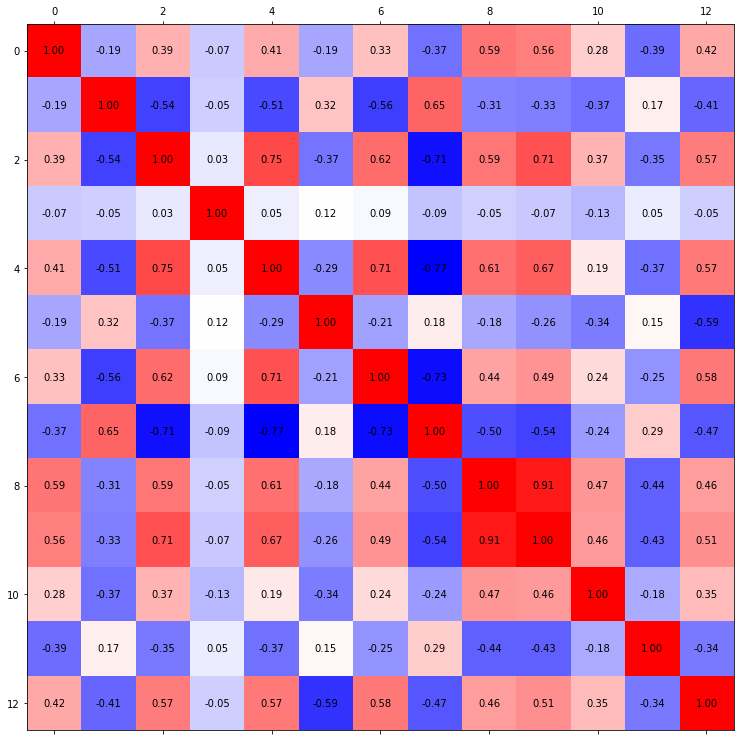

In [25]:
plt_corr(corr)

An additional test you can carry out is to see which feature mostly correlate *with the targets*, to see which features are most important for regression.

**Note that you should do this on the training set only. You can't look at the test set during training.**

To do so, you can create an "extended" data matrix `data_ext` where the targets have been added as a new feature column. Then you can run the correlation analysis to see which features are mostly related.

# **Exercise solution by Salvatore Cavallaro, 1000008690 (Part III)**

We create the extended matrix as following:

In [26]:
data_ext = torch.cat([X_training, y_training], 1)

In [27]:
corr_targets = correlation(data_ext[:,1:], num_training)

We plot the correlation matrix:

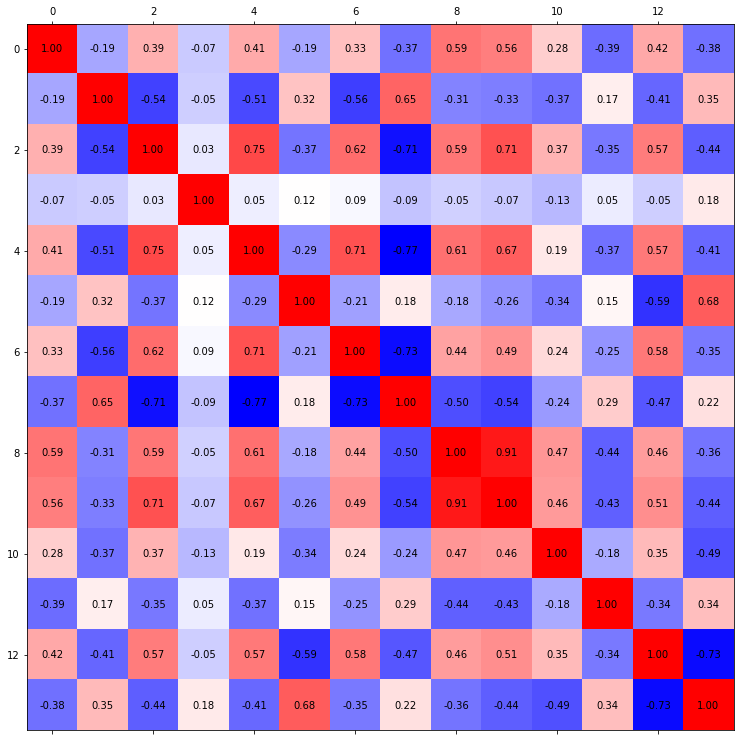

In [28]:
plt_corr(corr_targets)

Now it is time to build our model üòÅ. A first attempt is using *Normal Equation* on the training dataset:

In [29]:
theta = (X_training.t() @ X_training).inverse() @ X_training.t() @ y_training

We can get some accuracy information about this first model in terms of *Mean Square Error* and *Mean Absolute Error* on both *training set* and *test set*:

In [30]:
y_est_train = X_training @ theta
e_train = y_training - y_est_train
mse_train = (e_train**2).sum()/num_training
mae_train = (e_train).abs().sum()/num_training
print(mse_train.item())
print(mae_train.item())

21.63483942578887
3.274684001652958


In [33]:
y_est_train

tensor([[23.5499],
        [23.4391],
        [20.3218],
        [-4.7823],
        [ 4.0921],
        [17.5991],
        [29.1629],
        [19.1890],
        [29.4604],
        [17.9241],
        [25.3944],
        [24.5396],
        [25.4614],
        [26.6620],
        [22.9622],
        [27.2808],
        [37.3912],
        [21.4261],
        [17.0572],
        [29.1866],
        [27.0681],
        [35.7578],
        [39.5652],
        [11.9046],
        [22.5248],
        [17.9756],
        [18.5129],
        [19.1087],
        [19.4365],
        [15.9201],
        [22.6334],
        [20.9605],
        [25.1938],
        [28.5880],
        [42.9592],
        [20.4527],
        [16.7045],
        [20.3611],
        [ 8.2911],
        [32.4682],
        [20.1745],
        [11.3039],
        [28.3359],
        [16.5129],
        [27.7540],
        [25.6754],
        [13.1346],
        [34.3466],
        [23.0447],
        [34.3247],
        [23.8804],
        [22.6704],
        [20.

In [ ]:
y_est_test = X_test @ theta
e_test = y_test - y_est_test
mse_test = (e_test**2).sum()/num_test
mae_test = (e_test).abs().sum()/num_test
print(mse_test.item())
print(mae_test.item())

21.220713403176315
3.22377875382026


Finally, run some tests by:

- Computing the accuracy of your model when you remove/keep features that correlate with each other.
- Computing the accuracy of your model when you remove/keep features that correlate with the targets.

Using correlation matrix we can observe that some features have a very high correlation, therefore we can remove them from our dataset. 

In [ ]:
X_training_new = torch.cat([X_training[:, :3], X_training[:, 4].unsqueeze(1), X_training[:, 6].unsqueeze(1), X_training[:, 8:10], X_training[:, 11:]], 1)
X_test_new = torch.cat([X_test[:, :3], X_test[:, 4].unsqueeze(1), X_test[:, 6].unsqueeze(1), X_test[:, 8:10], X_test[:, 11:]], 1)

In [ ]:
theta_new = (X_training_new.t() @ X_training_new).inverse() @ X_training_new.t() @ y_training

In [ ]:
y_est_train_new = X_training_new @ theta_new
e_train_new = y_training - y_est_train_new
mse_train_new = (e_train_new**2).sum()/num_training
mae_train_new = (e_train_new).abs().sum()/num_training
print(mse_train_new.item())
print(mae_train_new.item())

24.33193905031764
3.361477273229174


In [ ]:
y_est_test_new = X_test_new @ theta_new
e_test_new = y_test - y_est_test_new
mse_test_new = (e_test_new**2).sum()/num_test
mae_test_new = (e_test_new).abs().sum()/num_test
print(mse_test_new.item())
print(mae_test_new.item())

23.121017800927333
3.3337851573362705


Above we can see that accuracy is worse both in training set and test set. We can also see a new version of correlation matrix of a training set without the correlated features:

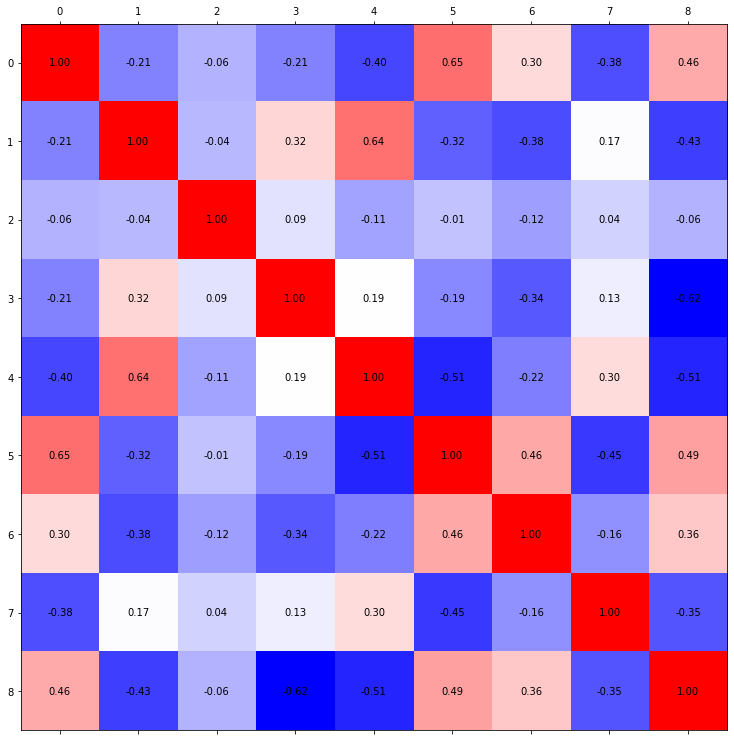

In [ ]:
corr_new = correlation(X_training_new[:,1:], num_training)
plt_corr(corr_new)

Finally we can try to evaluate a model without the feature correlated to *target*:

In [ ]:
X_training_ext = torch.cat([X_training[:, :13]], 1)
X_test_ext = torch.cat([X_test[:, :13]], 1)

In [ ]:
theta_ext = (X_training_ext.t() @ X_training_ext).inverse() @ X_training_ext.t() @ y_training

In [ ]:
y_est_train_ext = X_training_ext @ theta_ext
e_train_ext = y_training - y_est_train_ext
mse_train_ext = (e_train_ext**2).sum()/num_training
mae_train_ext = (e_train_ext).abs().sum()/num_training
print(mse_train_ext.item())
print(mae_train_ext.item())

26.71052154593938
3.437417472983656


In [ ]:
y_est_test_ext = X_test_ext @ theta_ext
e_test_ext = y_test - y_est_test_ext
mse_test_ext = (e_test_ext**2).sum()/num_test
mae_test_ext = (e_test_ext).abs().sum()/num_test
print(mse_test_ext.item())
print(mae_test_ext.item())

26.940178435681254
3.280418955231099
